In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
import torch
#import scripts.zero_shot_reconstruction as zs
from torch.utils.data import DataLoader, TensorDataset
#from gevar.data import WindTurbineDataset
# from notebooks.helpers import get_all_cross_corr_features, compute_max_cross_corr
# from notebooks.helpers import plot_mse_by_channel_with_total
# from notebooks.helpers import apply_pca_to_frames
from momentfm import MOMENTPipeline
from scipy.stats import multivariate_normal
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as patches

/home/scratch/ekaczmar/miniconda3/envs/reps-tsfm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/scratch/ekaczmar/miniconda3/envs/reps-tsfm/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/scratch/ekaczmar/miniconda3/envs/reps-tsfm/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def create_data(n_examples, dimension, control_range, anomaly_value=1, noise_level = .25, control_noise_level = .01, seed=1):
    torch.manual_seed(seed)
    slices = [slice(i*dimension, (i+1)*dimension) for i in range(3)]
    sig_len = dimension * 3
    control_data = torch.zeros(n_examples, sig_len)
    sensor_data = torch.zeros(n_examples, sig_len)
    rand_v = torch.rand((n_examples,3)) * (control_range[1] - control_range[0]) + control_range[0]
    for i in range(3):
        control_data[:, slices[i]] = rand_v[:,i][:, None]

    offsets = torch.rand(n_examples,)*6.28
    for i in range(3):
        sin_in = offsets[:, None] + anomaly_value*rand_v[:, i][:, None]*(torch.arange(dimension+1)[None, :].float() / dimension * 6.28*10)
        sin_in = sin_in[:, 1:]
        sin = torch.sin(sin_in)
        sensor_data[:, slices[i]] = sin

        cos = torch.cos(sin_in)
        offsets = torch.atan2(sin[:,-1], cos[:,-1])
        print(offsets)
        offsets[offsets < 0] += 6.28  # Ensure offsets are in [0, 2*pi]

        #sensor_data[:, slices[i]] = torch.sin(offsets[:, None] + control_data[:,slices[i]])
        #offsets = torch.asin(sensor_data[:, (i+1)*dimension-1])
        #is_down = sensor_data[:, (i+1)*dimension-1] - sensor_data[:, (i+1)*dimension-2] < 0
        #offsets[is_down] = offsets[is_down] + 3.14
       # print(offsets[0:4])

    sensor_data += torch.randn_like(sensor_data) * noise_level
    control_data += torch.randn_like(control_data) * control_noise_level
    return control_data, sensor_data

In [ ]:
#Train and test data: anomaly_value=1, control_range=(0,1)
control_data_train, sensor_data_train = create_data(10000, 170, (0, 1), anomaly_value=1, seed=1)
control_data_test, sensor_data_test = create_data(10000, 170, (0, 1), anomaly_value=1, seed=2)

tensor([-0.2036, -0.6039,  0.0287,  ..., -0.9102,  2.7976,  2.9917])
tensor([-1.5156,  1.2318, -2.8622,  ...,  0.7889, -1.7720,  0.0716])
tensor([-1.3388,  1.1975,  1.4838,  ...,  1.8125,  3.0060, -1.3090])
tensor([-1.5229, -0.3575, -2.6314,  ...,  2.2238, -2.4914, -2.9967])
tensor([-2.7312,  0.4707, -2.9035,  ..., -2.2881,  1.3713, -1.8407])
tensor([-0.4227,  1.6471, -2.0368,  ..., -2.8306, -1.7214,  3.0054])


Text(0.5, 0, 'Time')

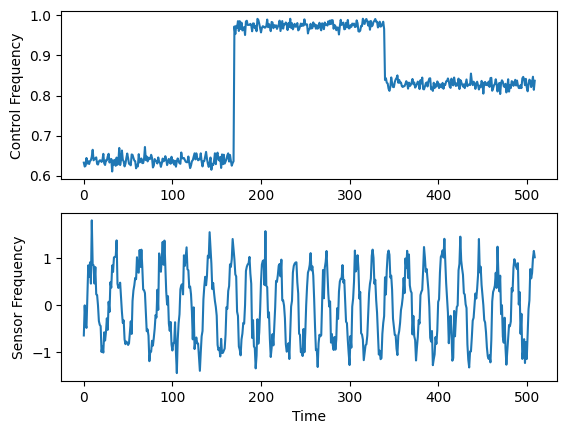

In [4]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(control_data_train[10, :].numpy())
ax[0].set_ylabel('Control Frequency')
ax[1].plot(sensor_data_train[10, :].numpy())
ax[1].set_ylabel('Sensor Frequency')
ax[1].set_xlabel('Time')

In [5]:
model = MOMENTPipeline.from_pretrained(
        "AutonLab/MOMENT-1-base", #("AutonLab/MOMENT-1-large")
        model_kwargs={"task_name": 'embedding'},
    )
embed_dim=512+256
model.init()
dir(model)

device = torch.device("cuda")
model = model.to(device)

/home/scratch/ekaczmar/miniconda3/envs/reps-tsfm/lib/python3.10/site-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [22]:

def compute_embeddings(control, sensor, batch_size=512):
    embeddings = torch.zeros(control.shape[0], embed_dim*2, device=device)
    dataset = TensorDataset(control, sensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for i, (control_batch, sensor_batch) in enumerate(tqdm(dataloader)):
            control_batch = control_batch.to(device)
            sensor_batch = sensor_batch.to(device)
            control_embeddings = model(x_enc=control_batch.unsqueeze(1)).embeddings
            sensor_embeddings = model(x_enc=sensor_batch.unsqueeze(1)).embeddings
            embeddings[i * batch_size:(i + 1) * batch_size, 0:embed_dim] = control_embeddings
            embeddings[i * batch_size:(i + 1) * batch_size, embed_dim:] = sensor_embeddings

    return embeddings.cpu().numpy(), embeddings[:, 0:embed_dim].cpu().numpy(), embeddings[:, embed_dim:].cpu().numpy()

In [23]:
embeddings_train, embeddings_control_train, embeddings_sensor_train = compute_embeddings(control_data_train, sensor_data_train)
embeddings_test, embeddings_control_test, embeddings_sensor_test = compute_embeddings(control_data_test, sensor_data_test)

100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


In [ ]:
#Dan's anomalies : anomaly_value = 0.1, conrtol_range=(0,1)
anomaly_value = .1
control_data_anomaly, sensor_data_anomaly = create_data(10000, 170, (0, 1), anomaly_value=anomaly_value, seed=3)
embeddings_anomaly, embeddings_control_anomaly, embeddings_sensor_anomaly = compute_embeddings(control_data_anomaly, sensor_data_anomaly)

tensor([-2.3947,  1.6334,  2.2313,  ...,  2.1322, -2.7484,  2.9475])
tensor([-1.7349, -1.6881,  0.6186,  ..., -2.3262,  0.2420,  2.8740])
tensor([ 0.0570, -1.3137, -1.9316,  ...,  1.6560, -2.6696,  1.8442])


100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


In [ ]:
#My anomalies : anomaly_value = 1, conrtol_range=(0,0.1)
anomaly_value = 1
control_data_anomaly_1, sensor_data_anomaly_1 = create_data(10000, 170, (0, 0.1), anomaly_value=anomaly_value, seed=3)
embeddings_anomaly_1, embeddings_control_anomaly_1, embeddings_sensor_anomaly_1 = compute_embeddings(control_data_anomaly_1, sensor_data_anomaly_1)

tensor([-2.3947,  1.6334,  2.2313,  ...,  2.1322, -2.7484,  2.9475])
tensor([-1.7349, -1.6881,  0.6186,  ..., -2.3262,  0.2420,  2.8740])
tensor([ 0.0570, -1.3137, -1.9316,  ...,  1.6560, -2.6696,  1.8442])


100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


Text(0.5, 0, 'Time')

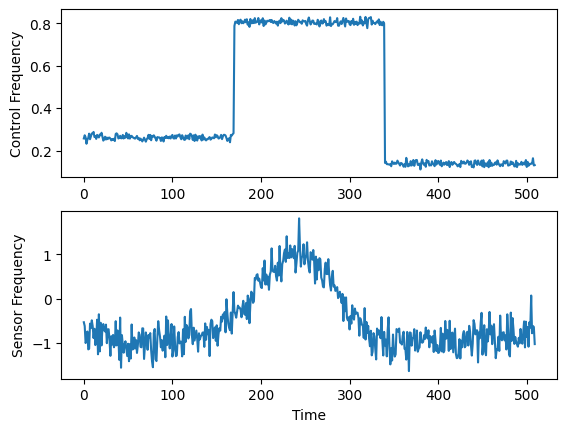

In [26]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(control_data_anomaly[10, :].numpy())
ax[0].set_ylabel('Control Frequency')
ax[1].plot(sensor_data_anomaly[10, :].numpy())
ax[1].set_ylabel('Sensor Frequency')
ax[1].set_xlabel('Time')

Text(0.5, 0, 'Time')

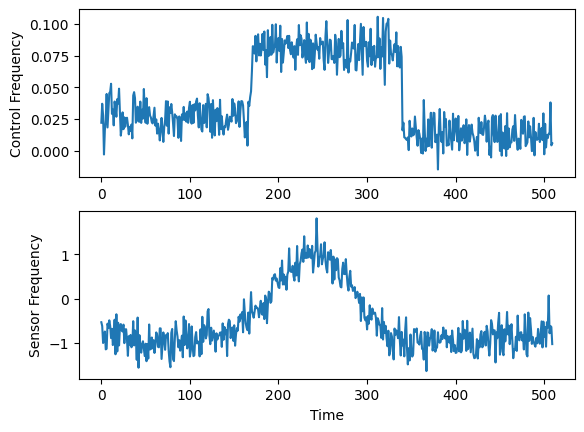

In [27]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(control_data_anomaly_1[10, :].numpy())
ax[0].set_ylabel('Control Frequency')
ax[1].plot(sensor_data_anomaly_1[10, :].numpy())
ax[1].set_ylabel('Sensor Frequency')
ax[1].set_xlabel('Time')

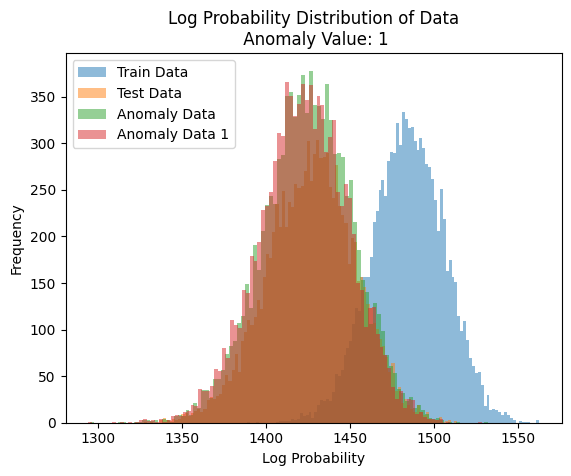

In [ ]:
# Multivariate normal estimation using control + sensor data
data_train = torch.cat((control_data_train, sensor_data_train), dim=1)
data_test = torch.cat((control_data_test, sensor_data_test), dim=1)
data_anomaly = torch.cat((control_data_anomaly, sensor_data_anomaly), dim=1)
data_anomaly_1 = torch.cat((control_data_anomaly_1, sensor_data_anomaly_1), dim=1)

mvn_data = multivariate_normal(mean=data_train.mean(axis=0), cov=np.cov(data_train.T))
mvn_embed = multivariate_normal(mean=embeddings_train.mean(axis=0), cov=np.cov(embeddings_train.T))

p_data_train = mvn_data.logpdf(data_train.numpy())
p_data_test = mvn_data.logpdf(data_test.numpy())
p_data_anomaly = mvn_data.logpdf(data_anomaly.numpy())
p_data_anomaly_1 = mvn_data.logpdf(data_anomaly_1.numpy())

p_embeddings_train = mvn_embed.logpdf(embeddings_train)
p_embeddings_test = mvn_embed.logpdf(embeddings_test)
p_embeddings_anomaly = mvn_embed.logpdf(embeddings_anomaly)
p_embeddings_anomaly_1 = mvn_embed.logpdf(embeddings_anomaly_1)

plt.hist(p_data_train, bins=100, alpha=0.5, label='Train Data')
plt.hist(p_data_test, bins=100, alpha=0.5, label='Test Data')
plt.hist(p_data_anomaly, bins=100, alpha=0.5, label='Anomaly Data')
plt.hist(p_data_anomaly_1, bins=100, alpha=0.5, label='Anomaly Data 1')
plt.legend()
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.title(f'Log Probability Distribution of Data\n Anomaly Value: {anomaly_value}')
#plt.savefig(f'../../plots/p_data_{anomaly_value}.png')
plt.show()

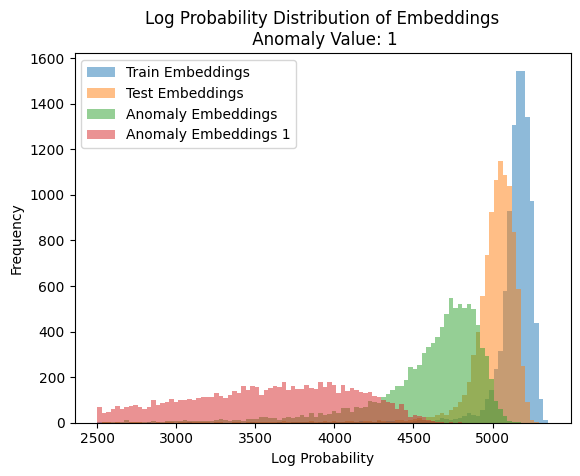

In [36]:
_, bins, _ = plt.hist(p_embeddings_train, bins=100, alpha=0.5, label='Train Embeddings')
plt.hist(p_embeddings_test, bins=bins, alpha=0.5, label='Test Embeddings')
plt.hist(p_embeddings_anomaly, bins=bins, alpha=0.5, label='Anomaly Embeddings')
plt.hist(p_embeddings_anomaly_1, bins=bins, alpha=0.5, label='Anomaly Embeddings 1')
plt.legend()
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.title(f'Log Probability Distribution of Embeddings\n Anomaly Value: {anomaly_value}')
#plt.savefig(f'../../plots/p_embed_{anomaly_value}.png')
#plt.xscale('log')
plt.show()

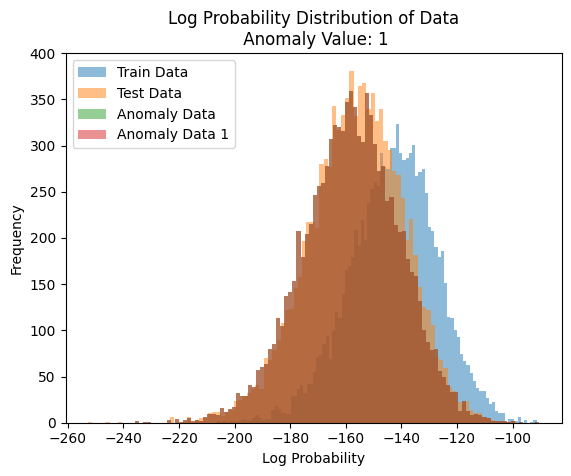

In [ ]:
# # Multivariate normal estimation using sensor data obly (no information about control)
mvn_data = multivariate_normal(mean=sensor_data_train.mean(axis=0), cov=np.cov(sensor_data_train.T))
mvn_embed = multivariate_normal(mean=embeddings_sensor_train.mean(axis=0), cov=np.cov(embeddings_sensor_train.T))

p_data_train = mvn_data.logpdf(sensor_data_train.numpy())
p_data_test = mvn_data.logpdf(sensor_data_test.numpy())
p_data_anomaly = mvn_data.logpdf(sensor_data_anomaly.numpy())
p_data_anomaly_1 = mvn_data.logpdf(sensor_data_anomaly_1.numpy())

p_embeddings_train = mvn_embed.logpdf(embeddings_sensor_train)
p_embeddings_test = mvn_embed.logpdf(embeddings_sensor_test)
p_embeddings_anomaly = mvn_embed.logpdf(embeddings_sensor_anomaly)
p_embeddings_anomaly_1 = mvn_embed.logpdf(embeddings_sensor_anomaly_1)

plt.hist(p_data_train, bins=100, alpha=0.5, label='Train Data')
plt.hist(p_data_test, bins=100, alpha=0.5, label='Test Data')
plt.hist(p_data_anomaly, bins=100, alpha=0.5, label='Anomaly Data')
plt.hist(p_data_anomaly_1, bins=100, alpha=0.5, label='Anomaly Data 1')
plt.legend()
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.title(f'Log Probability Distribution of Data\n Anomaly Value: {anomaly_value}')
#plt.savefig(f'../../plots/p_data_{anomaly_value}.png')
plt.show()

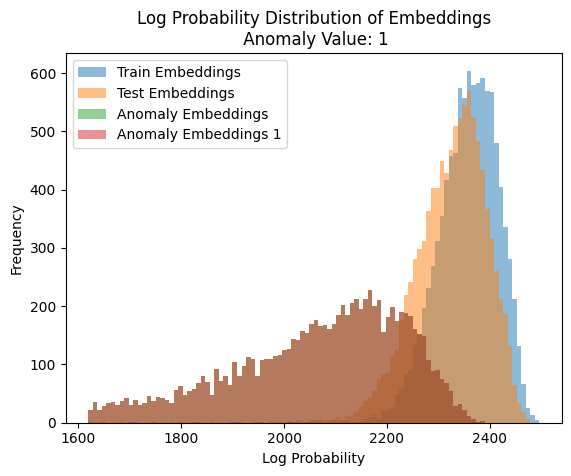

In [30]:
_, bins, _ = plt.hist(p_embeddings_train, bins=100, alpha=0.5, label='Train Embeddings')
plt.hist(p_embeddings_test, bins=bins, alpha=0.5, label='Test Embeddings')
plt.hist(p_embeddings_anomaly, bins=bins, alpha=0.5, label='Anomaly Embeddings')
plt.hist(p_embeddings_anomaly_1, bins=bins, alpha=0.5, label='Anomaly Embeddings 1')
plt.legend()
plt.xlabel('Log Probability')
plt.ylabel('Frequency')
plt.title(f'Log Probability Distribution of Embeddings\n Anomaly Value: {anomaly_value}')
#plt.savefig(f'../../plots/p_embed_{anomaly_value}.png')
#plt.xscale('log')
plt.show()